# The Basics of TOAD

TOAD's core functionality is exposed through the `TOAD` class, which analyzes netCDF files or xarray datasets. The two primary methods - `compute_shifts` and `compute_clusters` - handle the main analysis steps. Additional helper functions and visualization tools make it easy to explore and understand the results.

**The following tutorial will guide you through the basic workflow of TOAD (Viel Spaß! 🎉):**


In [1]:
# 1. Uncomment this line to install the library in editable mode, if not already installed
# %pip install -e ..

# 2. After installation, restart notebook

In [1]:
# Prerequisites
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (12, 5)

# Include this once we have a published release to fetch test data
# from toad.utils import download_test_data
# download_test_data()

First, let's load some data. Here we use data from Garbe (2020) which shows near-equilibrium ice-thickness for different levelts of warming.


## Init the TOAD object

Init toad object with an xarray or .nc file. The TOAD object wraps the xarray datasets and provides analysis functions etc. You can always access the underlying xarray dataset with `td.data`.


/home/lukasro/Documents/TIPMIP/toad/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



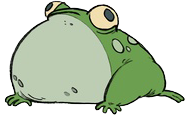

In [2]:
from toad import TOAD

# Init the TOAD object with an xarray or .nc file
# We are using the GMST dimension as time dimension
# This dataset already has computed shifts.
td = TOAD("test_data/garbe_2020_antarctica.nc", time_dim="GMST")
td

In [3]:
# we can reference the xr dataset through the .data property.
# Let's just coarsen the data to speed up computation
td.data = td.data.coarsen(x=2, y=2, GMST=2, boundary="trim").reduce(np.mean)

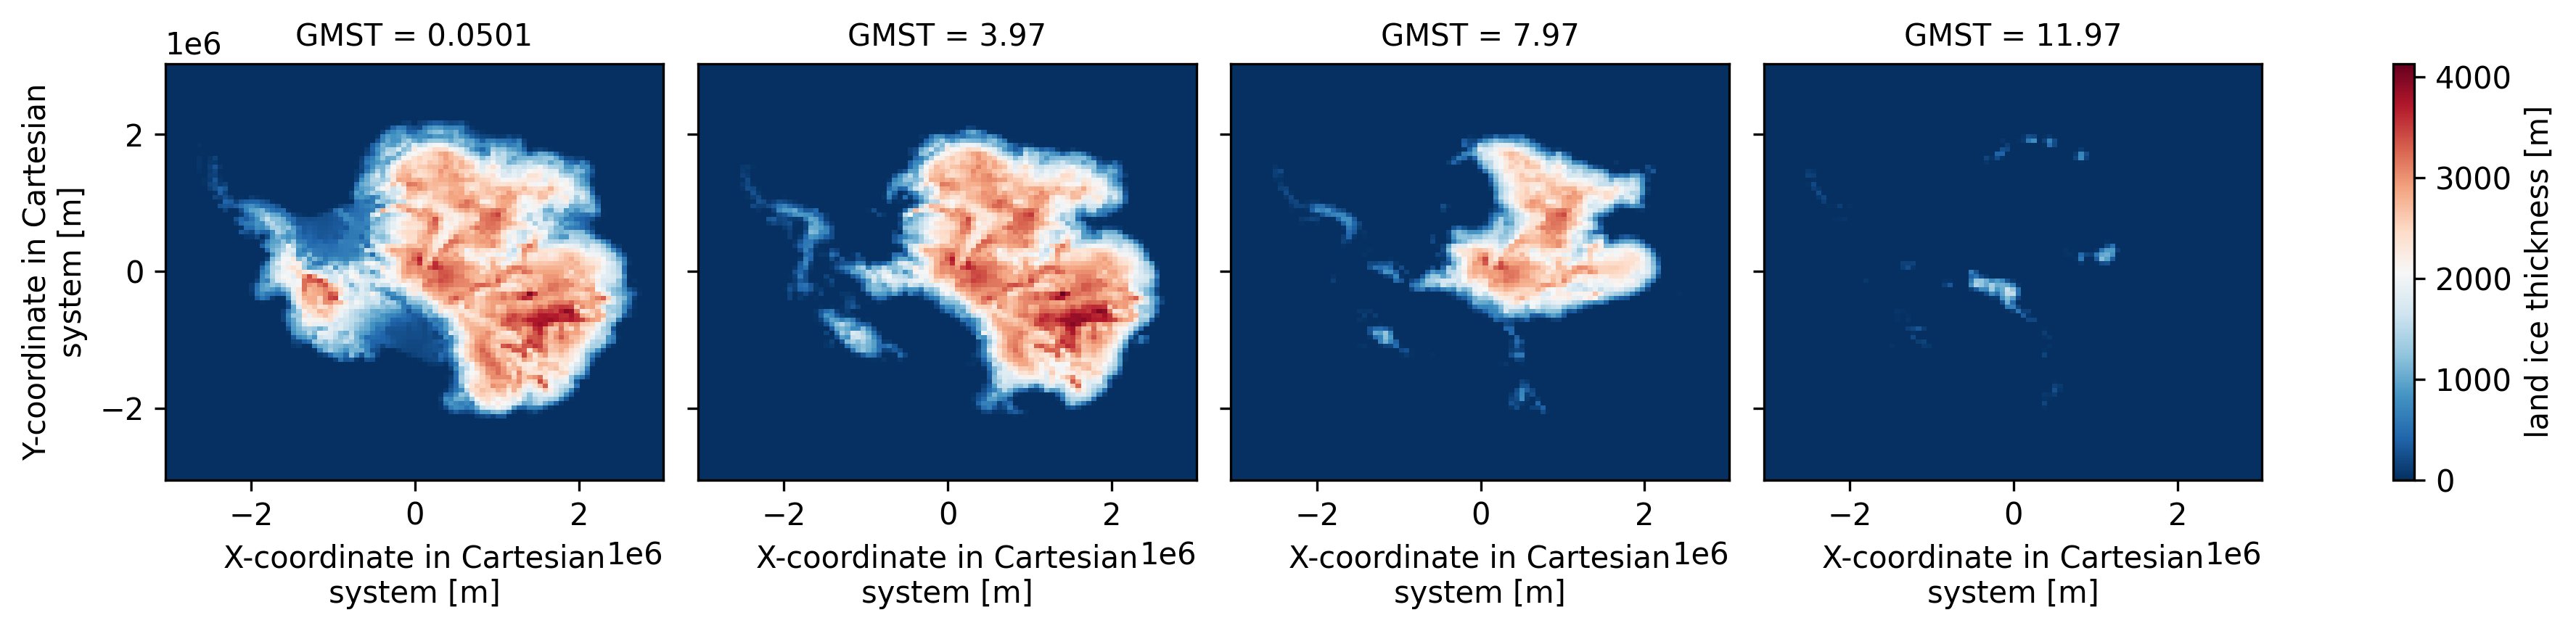

In [4]:
# quick look at the data
td.data.thk.sel(GMST=[0, 4, 8, 12], method="nearest").plot(col="GMST", cmap="RdBu_r")

## Compute shifts

First step of the pipeline is to compute shifts. The function `compute_shifts()` requires two parameters: `var` (the variable to analyze) and `method` (the shifts detection method). Currently TOAD uses `ASDETECT` ([Boulton & Lenton, 2019](https://ore.exeter.ac.uk/repository/handle/10871/40431)) as its default method.

`ASDETECT` analyzes gradients in multiple overlapping windows of different sizes. At each time point, it returns a score between -1 (strong negative shift) and 1 (strong positive shift), where the magnitude indicates how many window sizes detected a significant gradient (exceeding ±3 median absolute deviations from the median gradient). For implementation details, see [asdetect.py](../toad/shifts_detection/methods/asdetect.py). You can also implement your own shifts detection algorithm, see [shift_detection_methods.ipynb](../tutorials/shift_detection_methods.ipynb) for details.

After computing shifts, TOAD automatically adds a new variable to the dataset (`td.data`) with the suffix `_dts`. For example, shifts computed for the variable `thk` will be stored as `thk_dts`.


In [13]:
from toad.shifts import ASDETECT

td.compute_shifts("thk", method=ASDETECT(ignore_nan_warnings=True), overwrite=True)

INFO: New shifts variable thk_dts: min/mean/max=-1.000/-0.219/1.000 using 3589 grid cells. Skipped 60.2% grid cells: 0 NaN, 5436 constant.


In this figure the bottom plot shows the computed shifts timeseries in which we see a (negative) peak around the time of the abrupt shift in the ice-thickness timeseries (top).


/tmp/ipykernel_11217/2721635791.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


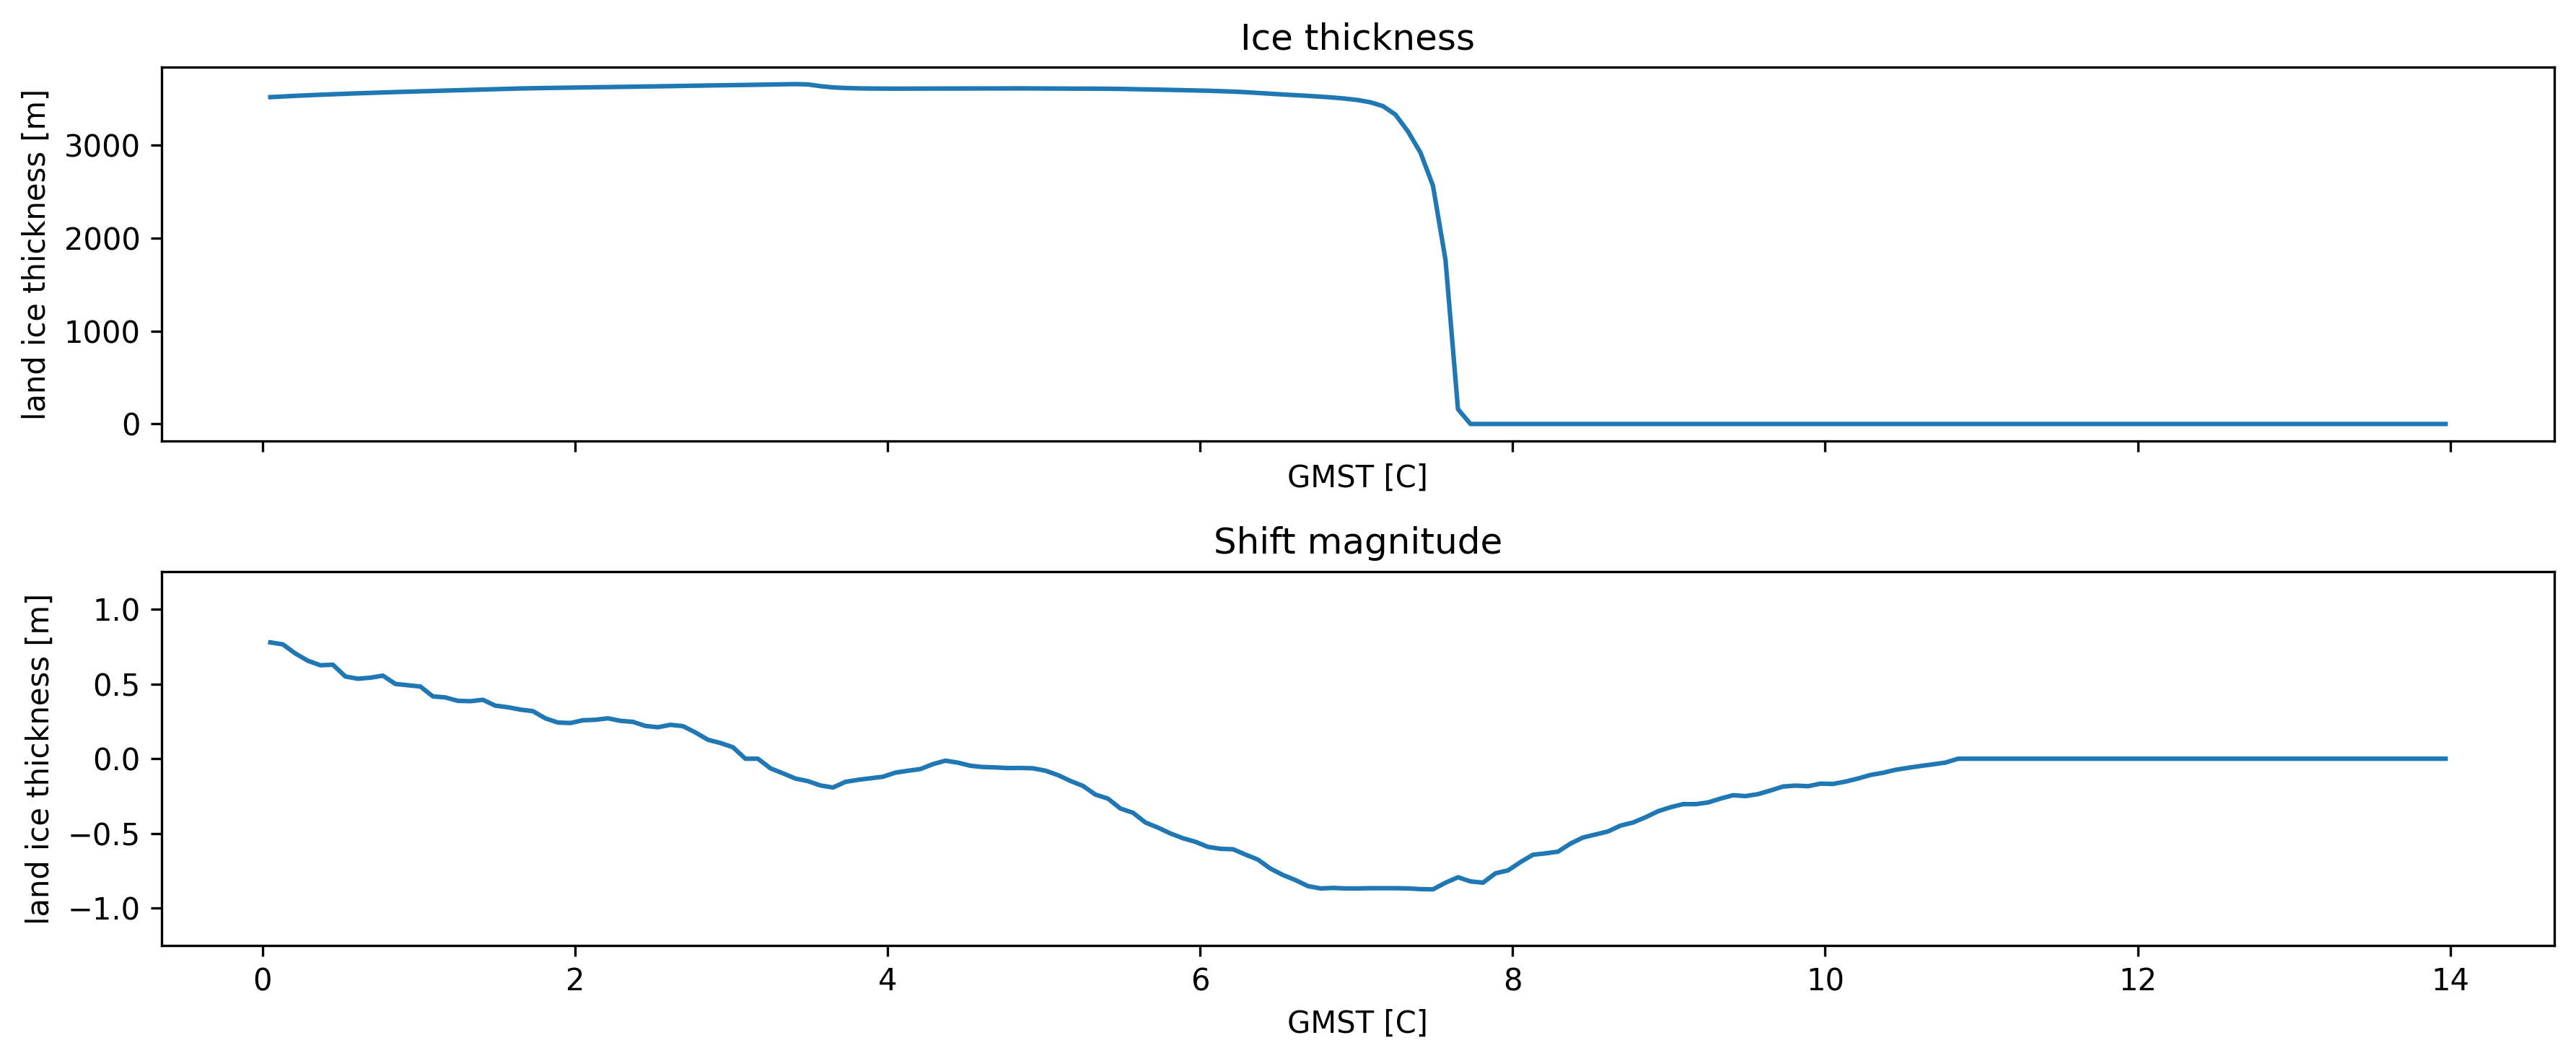

In [14]:
fig, axs = plt.subplots(2, sharex=True)
idx, idy = 75, 39
td.data.thk.isel(x=idx, y=idy).plot(ax=axs[0])
td.data.thk_dts.isel(x=idx, y=idy).plot(ax=axs[1])
axs[0].set_title("Ice thickness")
axs[1].set_title("Shift magnitude")
axs[1].set_ylim(-1.25, 1.25)
fig.tight_layout()
fig.show()

To compute clusters, we will have to specify the minimum shift magnitude for a shift to be considered abrupt. Plotting the distribution of all shift magnitudes gives us a sense of the data. Below we see that the data is generally dominated by negative shifts (ice melting) and that many of them are abrupt.


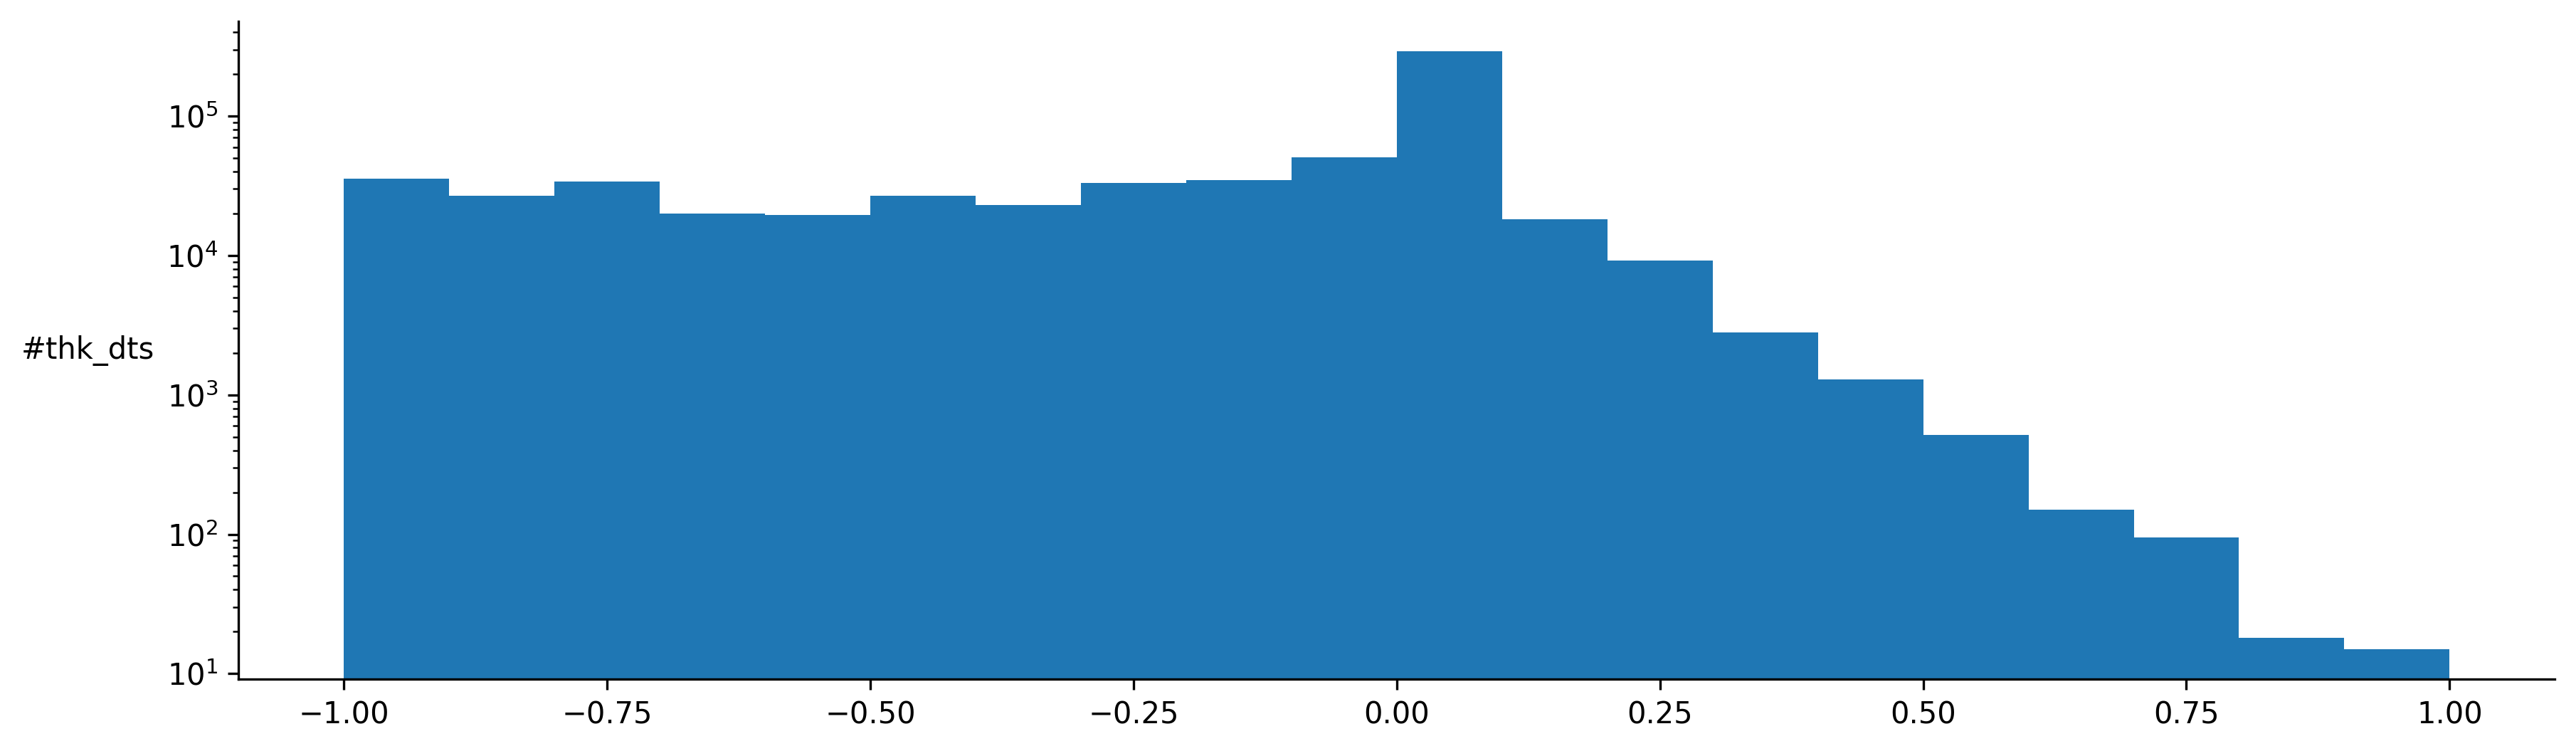

In [ ]:
td.plot.shifts_distribution(figsize=(14, 4));

## Compute clusters

Once we have a new timeseries reflecting the abruptness for each cell, it's time to compute the clustering.

The `compute_clusters()` function requires a `var` name, in our case `thk` and a method. TOAD can take any clustering method from the [scikit-learn library](https://scikit-learn.org/stable/api/sklearn.cluster.html), but you can also write your own clustering algorithm, see [clustering_methods.ipynb](../tutorials/clustering_methods.ipynb) for details.

The `shift_threshold` parameter determines which shifts are considered significant enough for clustering. By default, TOAD checks if the absolute value of the shift exceeds the threshold. You can also detect only positive or negative shifts by setting the `shift_direction` parameter. The `shift_selection` parameter controls how shift values are selected for clustering:

- `local` (**default**): Finds peaks within individual shift episodes. For each segment that crosses the `shift_threshold`, only the local maximum is used for clustering. This allows detecting multiple shifts at the same location.

- `global`: Finds the single strongest shift per grid cell. Only the maximum shift value that exceeds the `shift_threshold` is used for clustering at each location.

- `all`: Includes every shift value that exceeds the `shift_threshold`. Unlike the other options, no peak detection is performed - all qualifying points are included in the clustering. This can reveal connections between clusters that evolve gradually over time, like cascading tipping points, but comes at the cost of significantly increased computation time.

In this example, we use [HDBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html#sklearn.cluster.HDBSCAN) which has intuitive hyperparameters and supports clusters of different densities. Tip: For large datasets [fast_hdbscan](https://github.com/TutteInstitute/fast_hdbscan) can be significantly faster.

Behind the scenes, TOAD clusters data points in multiple dimensions. By default all values are scaled using a [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). The time dimension can be scaled relative to space using the `time_scale_factor` parameter.


In [ ]:
from sklearn.cluster import HDBSCAN  # type: ignore

# Minimum required input is a variable name and a method. For HDBSCAN we also need a filtering function.
td.compute_clusters(
    var="thk",  # toad will find computed shifts for this variable
    method=HDBSCAN(min_cluster_size=15),
    shift_threshold=0.9,
)

INFO: New cluster variable thk_dts_cluster: Identified 15 clusters in 2,348 pts; Left 15.3% as noise (360 pts).


Calling the toad object we can now see that new variables have been added



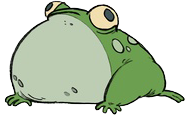

In [ ]:
td

## Plotting

TOAD provides a few in-built plotting functions for quickly assesing the results. They can be accessed through `td.plot`. Below is an example of the `cluster_overview` plot, which combines a `cluster_map` and a `cluster_aggregate` plot. On the right hand side, you see the mean ice-volume trajectory for each cluster along with the range. On top of each each curve is a shading that indicates the full time/forcing range in which the cluster is in an abrupt shift as well as the 68% interquantile. Each trajectory in the cluster may only be an active member of the cluster for a smaller number of timesteps than the duration of the whole cluster. Please see [visualisation_examples.ipynb](../tutorials/visualisation_examples.ipynb) for more examples.


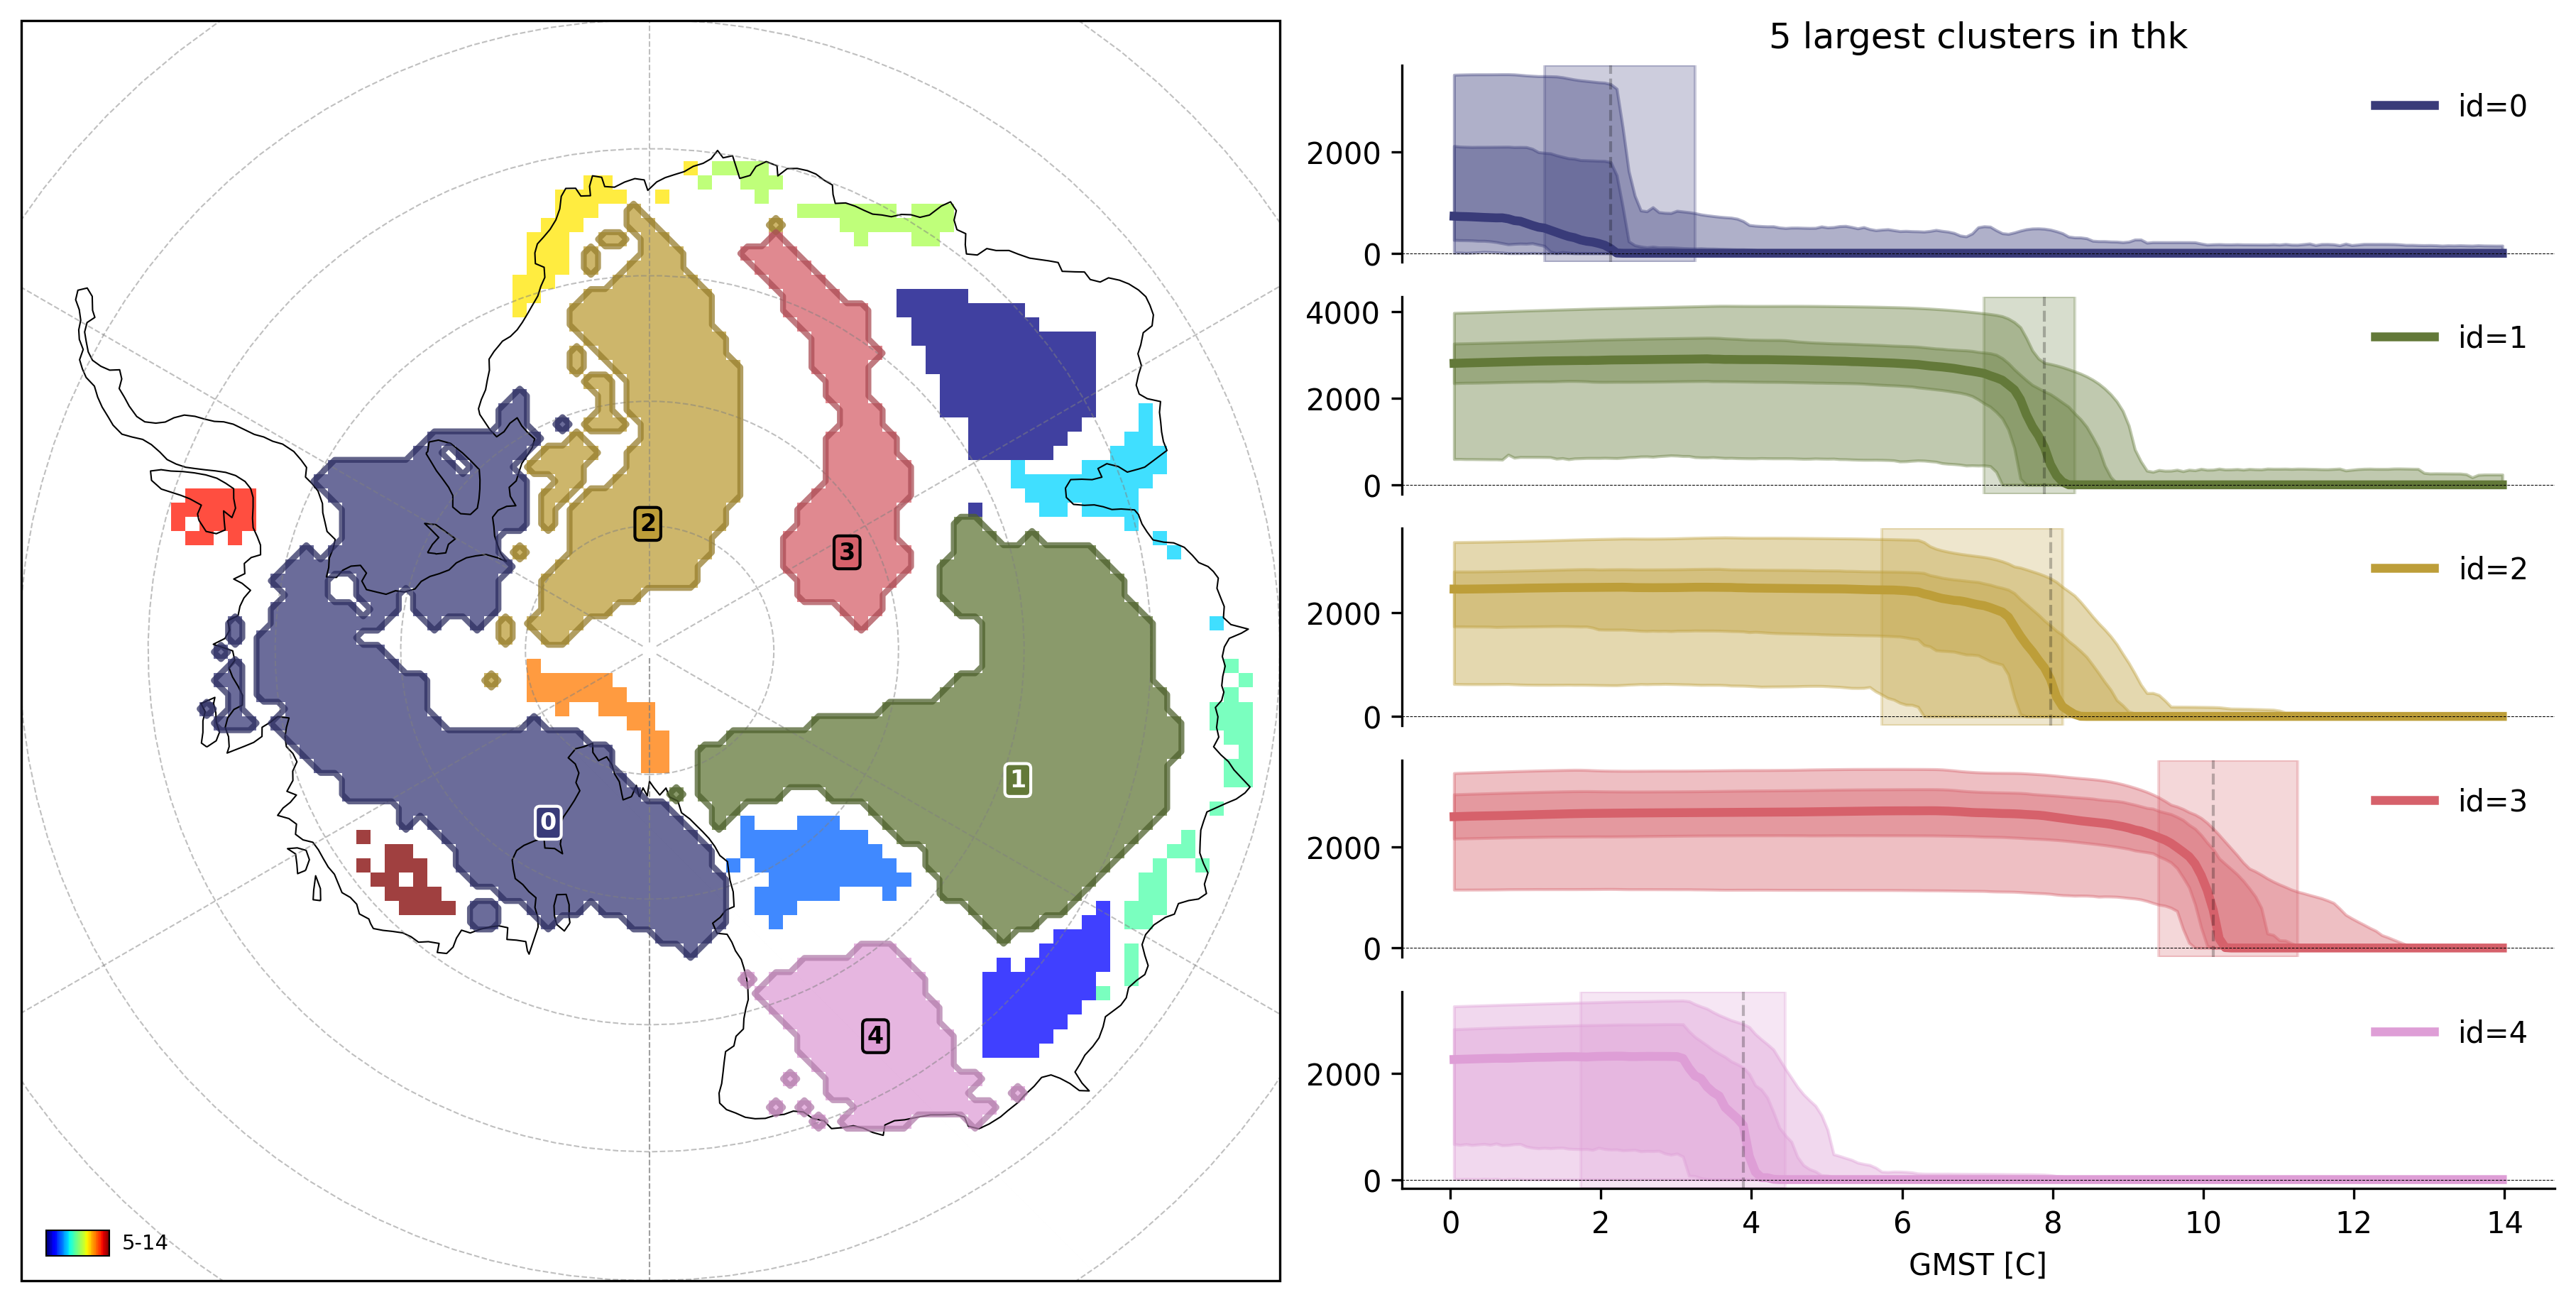

In [ ]:
td.plot.cluster_overview(
    "thk",
    cluster_ids=range(5),  # plot the 5 largest clusters
    projection="south_pole",
);

Example of a `cluster_timeseries` plot.


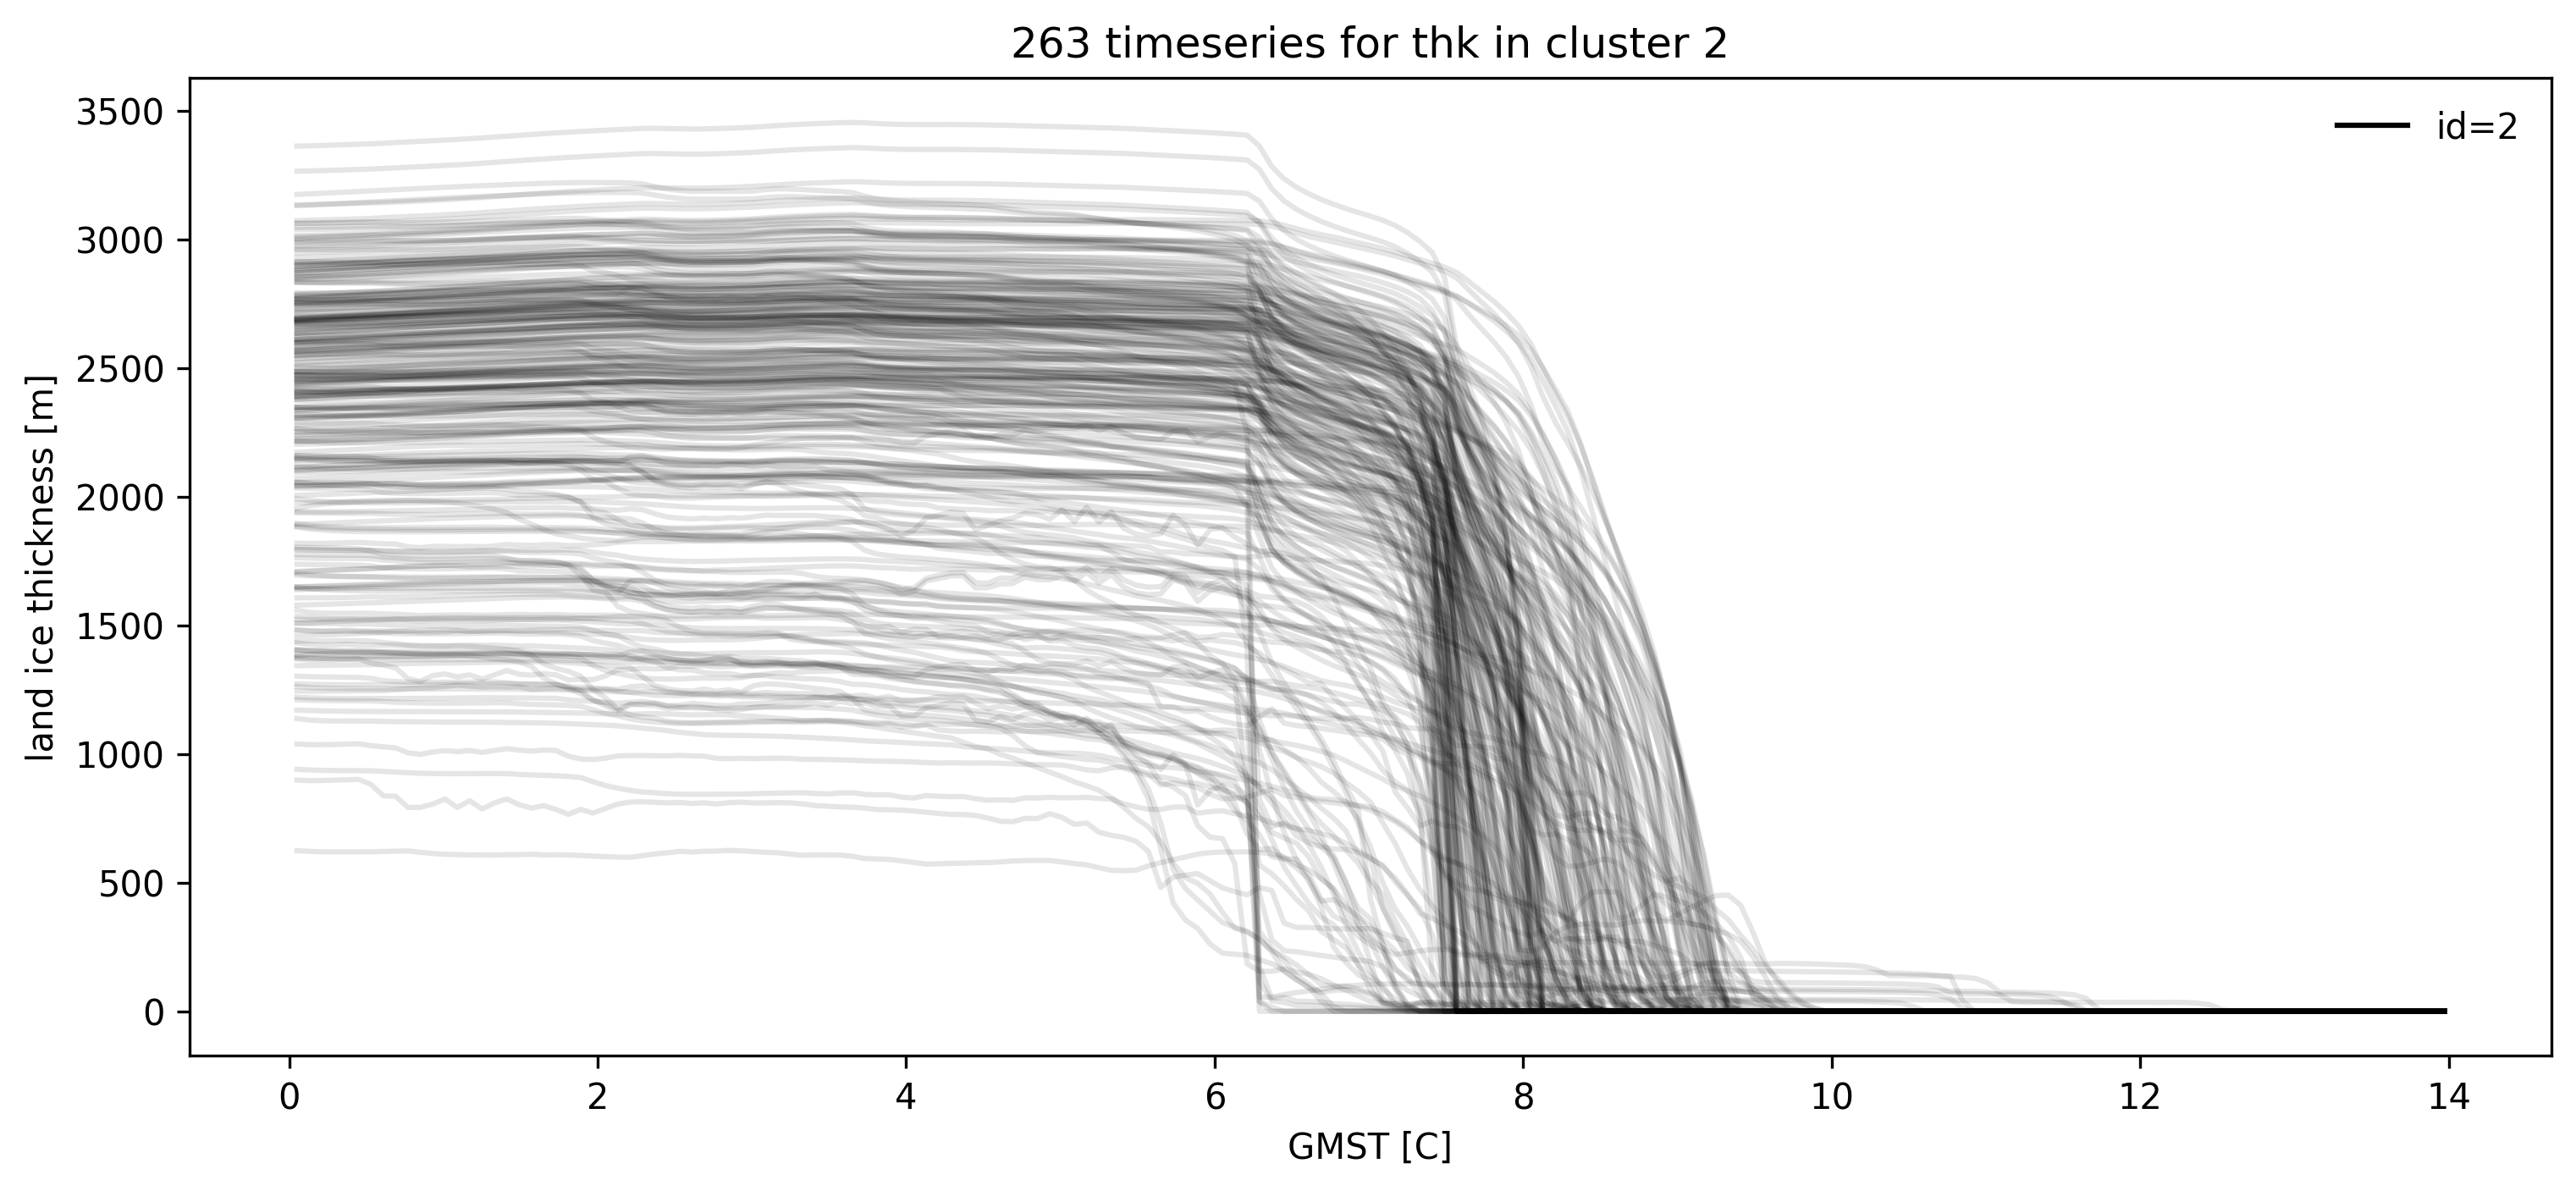

In [ ]:
td.plot.cluster_timeseries("thk", cluster_ids=[2], color="black", alpha=0.1);

## Postprocessing


Save the dataset with the new additions using the `td.save()` function. This automatically adds compression.


In [ ]:
# Use original path name with suffix
# td.save(suffix="_my_computed_toad_data")

# Use a different path name
# td.save(path="my_computed_toad_data.nc")

By default, results from shifts and cluster computations are merged into the original dataset (`td.data`). While you can access everything directly from `td.data`, TOAD provides helper functions to easily extract insights from the results.


In [ ]:
td.data

<xarray.Dataset> Size: 19MB
Dimensions:          (GMST: 175, y: 95, x: 95)
Coordinates:
  * GMST             (GMST) float64 1kB 0.0501 0.1301 0.2101 ... 13.89 13.97
  * y                (y) float64 760B -3.016e+06 -2.952e+06 ... 2.936e+06 3e+06
  * x                (x) float64 760B -3.016e+06 -2.952e+06 ... 2.936e+06 3e+06
Data variables:
    thk              (GMST, y, x) float32 6MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    thk_dts          (GMST, y, x) float32 6MB nan nan nan nan ... nan nan nan
    thk_dts_cluster  (GMST, y, x) int32 6MB -1 -1 -1 -1 -1 -1 ... -1 -1 -1 -1 -1
Attributes: (12/13)
    CDI:            Climate Data Interface version 1.9.6 (http://mpimet.mpg.d...
    proj4:          +lon_0=0.0 +ellps=WGS84 +datum=WGS84 +lat_ts=-71.0 +proj=...
    CDO:            Climate Data Operators version 1.9.6 (http://mpimet.mpg.d...
    source:         PISM (development v1.0-535-gb3de48787 committed by Julius...
    institution:    PIK / Potsdam Institute for Climate Impact Research
    author:         Julius Garbe (julius.garbe@pik-potsdam.de)
    ...             ...
    title:          garbe_2020_antarctica
    Conventions:    CF-1.9
    projection:     Polar Stereographic South (71S,0E)
    ice_density:    910. kg m-3
    NCO:            netCDF Operators version 4.7.8 (Homepage = http://nco.sf....
    Modifications:  Modified by Jakob Harteg (jakob.harteg@pik-potsdam.de) Se...

#### Cluster counts


In [ ]:
# Get a list of identified clusters sorted by number of cells in each cluster
# -1 = unclustered cells
td.get_cluster_counts("thk")

{0: 536,
 1: 474,
 2: 264,
 3: 139,
 4: 138,
 5: 115,
 6: 57,
 7: 55,
 8: 47,
 9: 38,
 10: 31,
 11: 30,
 12: 27,
 13: 19,
 14: 18}

#### Cluster ids


In [ ]:
# short hand for getting just the ids of the (sorted) clusters
td.get_cluster_ids("thk")

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

#### Shift method attributes


In [ ]:
# Parameters used for shift computation are saved as attrs
td.get_shifts("thk").attrs  # or directly td.data.thk_dts.attrs

{'standard_name': 'land_ice_thickness',
 'long_name': 'land ice thickness',
 'units': 'm',
 'pism_intent': 'model_state',
 'time_dim': 'GMST',
 'method_name': 'ASDETECT',
 'toad_version': '0.3',
 'base_variable': 'thk',
 'variable_type': 'shift',
 'method_ignore_nan_warnings': 'True',
 'method_lmin': '5'}

#### Cluster method attributes


In [ ]:
# Parameters used for clustering computation are saved as attrs
td.get_clusters("thk").attrs  # or directly td.data.thk_cluster.attrs

{'standard_name': 'land_ice_thickness',
 'long_name': 'land ice thickness',
 'units': 'm',
 'pism_intent': 'model_state',
 'time_dim': 'GMST',
 'method_name': 'HDBSCAN',
 'toad_version': '0.3',
 'base_variable': 'thk',
 'variable_type': 'cluster',
 'method_ignore_nan_warnings': 'True',
 'method_lmin': '5',
 'cluster_ids': array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 'shift_threshold': 0.9,
 'shift_selection': 'local',
 'shift_direction': 'both',
 'scaler': 'StandardScaler',
 'time_scale_factor': 1,
 'n_data_points': 2348,
 'runtime_preprocessing': 0.026661157608032227,
 'runtime_clustering': 0.030622243881225586,
 'runtime_total': 0.05728340148925781,
 'shifts_variable': 'thk_dts',
 'method_algorithm': 'auto',
 'method_allow_single_cluster': 'False',
 'method_alpha': '1.0',
 'method_cluster_selection_epsilon': '0.0',
 'method_cluster_selection_method': 'eom',
 'method_copy': 'False',
 'method_leaf_size': '40',
 'method_metric': 'euclidean',
 'method_min_clu

#### Cluster mask


In [ ]:
# Get a mask for all cells in a cluster
td.get_cluster_mask("thk", cluster_id=6)

<xarray.DataArray 'thk_dts_cluster' (GMST: 175, y: 95, x: 95)> Size: 2MB
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
...
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]],
      shape=(175, 95, 95))
Coordinates:
  * GMST     (GMST) float64 1kB 0.0501 0.1301 0.2101 ... 13.81 13.89 13.97
  * y        (y) float64 760B -3.016e+06 -2.952e+06 ... 2.936e+06 3e+06
  * x        (x) float64 760B -3.016e+06 -2.952e+06 ... 2.936e+06 3e+06

#### Timeseries


Text(0.5, 1.0, 'Cluster 2')

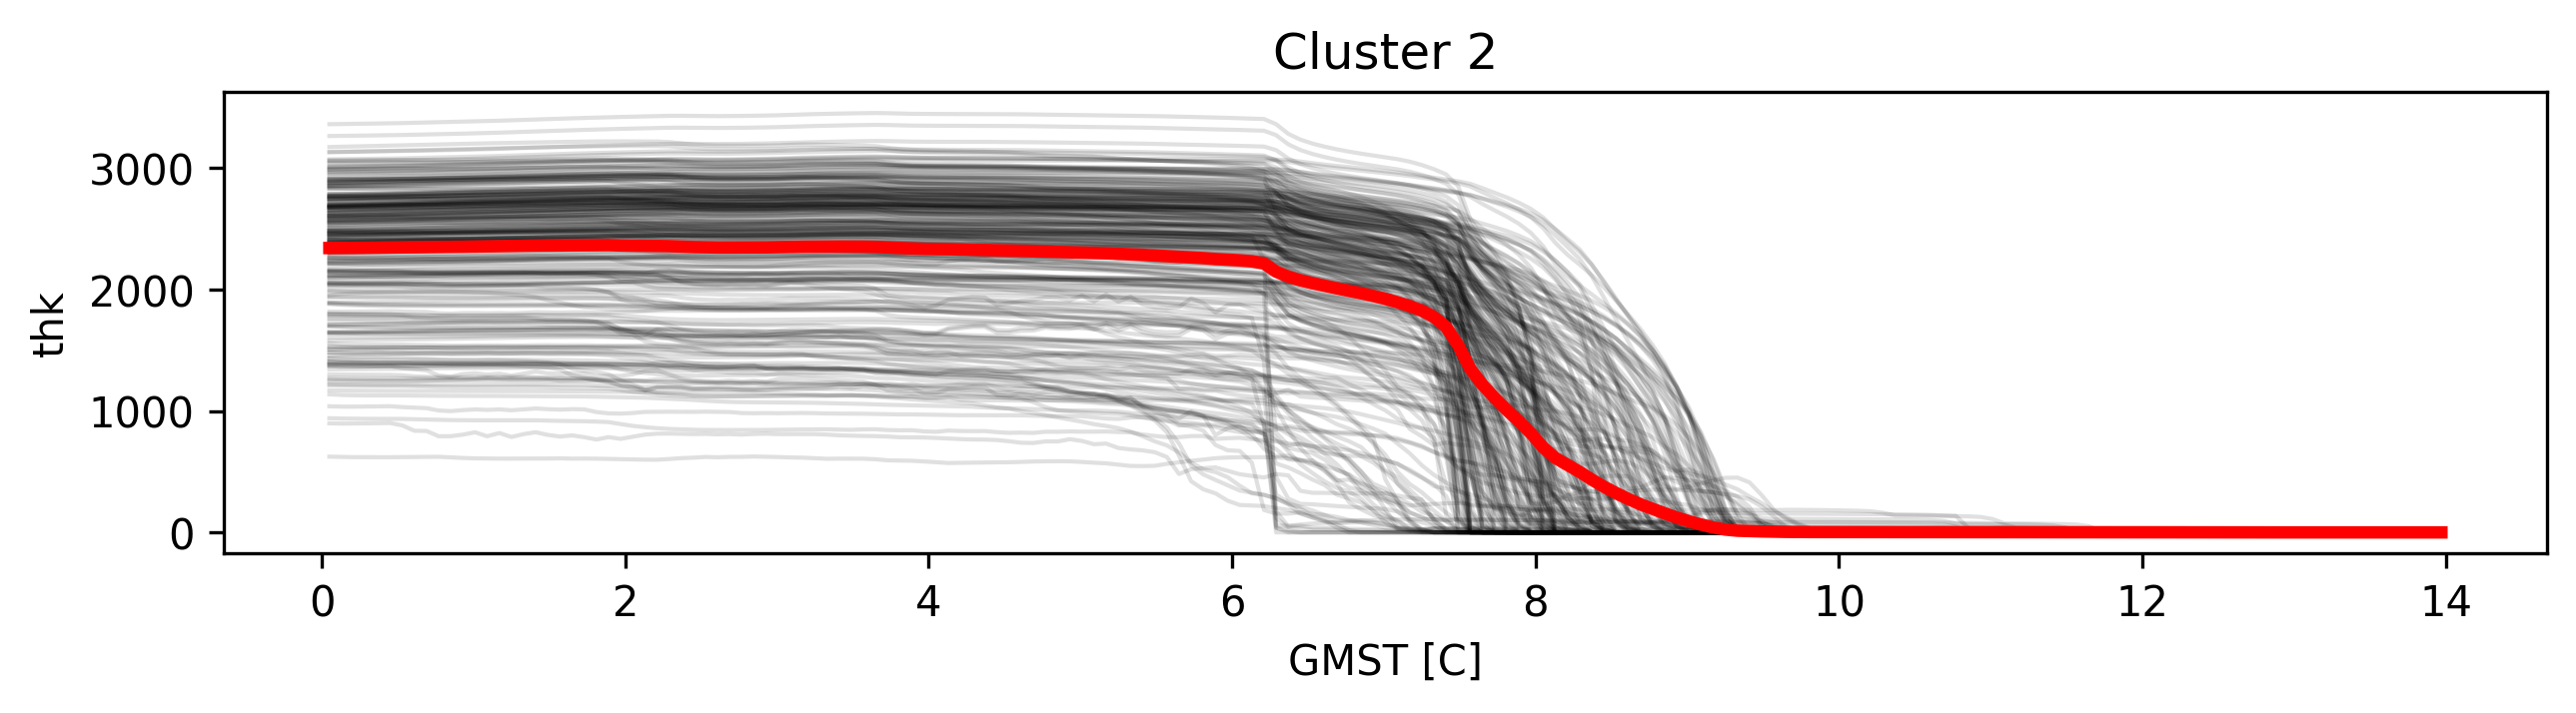

In [ ]:
# Get time series from clusters
timeseries = td.get_cluster_timeseries("thk", cluster_id=2)

# get mean of timeseries
mean = td.get_cluster_timeseries("thk", cluster_id=2, aggregation="mean")


# Eg: to plot:
plt.figure(figsize=(10, 2))
for ts in timeseries:
    ts.plot(color="k", alpha=0.12, lw=1)
mean.plot(lw=3, color="r")
plt.title("Cluster 2")

### Stats

Calling `td.cluster_stats(var)` and the submodules `time` and `space` will expose more statistics related helper functions.


#### Time stats


In [ ]:
# get start time for cluster 5
td.cluster_stats(var="thk").time.start(cluster_id=5)

7.2501

In [ ]:
# get all stats in dictionary
td.cluster_stats("thk").time.all_stats(5)

{'_get_cluster_numeric_times': array([7.2501, 7.3301, 7.4101, 7.4901, 7.5701, 7.6501, 7.7301, 7.8101,
        7.8901, 7.9701, 8.0501, 8.2901, 8.3701]),
 'duration': 1.120000000000001,
 'duration_timesteps': 14,
 'end': 8.3701,
 'end_timestep': 104,
 'iqr_50': (7.5701, 7.8101),
 'iqr_68': (7.4901, 7.8101),
 'iqr_90': (7.4101, 8.0501),
 'mean': 7.754715384615384,
 'median': 7.7301,
 'membership_peak': 7.5701,
 'membership_peak_density': 0.003988919667590028,
 'start': 7.2501,
 'start_timestep': 90,
 'std': 0.33851747789477094,
 'steepest_gradient': 8.2101,
 'steepest_gradient_timestep': 99.0}

#### Space stats


In [ ]:
# Get mean x,y position of cluster 5
td.cluster_stats(var="thk").space.mean(cluster_id=5)

(1242504.347826087, 1589217.391304348)

In [ ]:
td.cluster_stats("thk").space.all_stats(5)

{'central_point_for_labeling': (1144000.0, 1656000.0),
 'footprint_cumulative_area': 115,
 'footprint_mean': (1242504.347826087, 1589217.391304348),
 'footprint_median': (1272000.0, 1592000.0),
 'footprint_std': (203489.1888555665, 217385.6834055924),
 'mean': (1242504.347826087, 1589217.391304348),
 'median': (1272000.0, 1592000.0),
 'std': (203489.1888555665, 217385.6834055924)}

#### Cluster scoring

We have a few scores available already that aim to quantify the quality of a cluster.

`score_heaviside()` evaluates how closely the spatially aggregated cluster time series resembles a perfect Heaviside function. A score of 1 indicates a perfect step function, while 0 indicates a linear trend.

`score_consistency()` measures internal coherence using hierarchical clustering. Higher scores indicate more internally consistent clusters, which is useful for assessing cluster quality.

`score_spatial_autocorrelation()` measures average pairwise similarity (R²) between time series within a cluster. Higher scores mean more similar behavior within the cluster. This provides a fast computation of spatial coherence.

`score_nonlinearity()` measures deviation from linearity using RMSE and can be normalized against unclustered data. Higher scores indicate more nonlinear behavior, which is good for detecting complex temporal patterns.


In [ ]:
td.cluster_stats("thk").general.score_heaviside(5, aggregation="mean")

0.13140122986120165

# Example 2

Let's just try some different data: Mean summer near-surface air temperature.

Note: To prevent clustering distortions near the poles (the 'polar problem'), TOAD automatically regrids datasets detected in lat/lon coordinates onto an equal-area grid before analysis.


INFO: New shifts variable tas_dts: min/mean/max=-0.875/0.015/1.000 using 34992 grid cells. Skipped 0.0% grid cells: 0 NaN, 0 constant.
INFO: New cluster variable tas_dts_cluster: Identified 10 clusters in 3,008 pts; Left 4.8% as noise (143 pts).


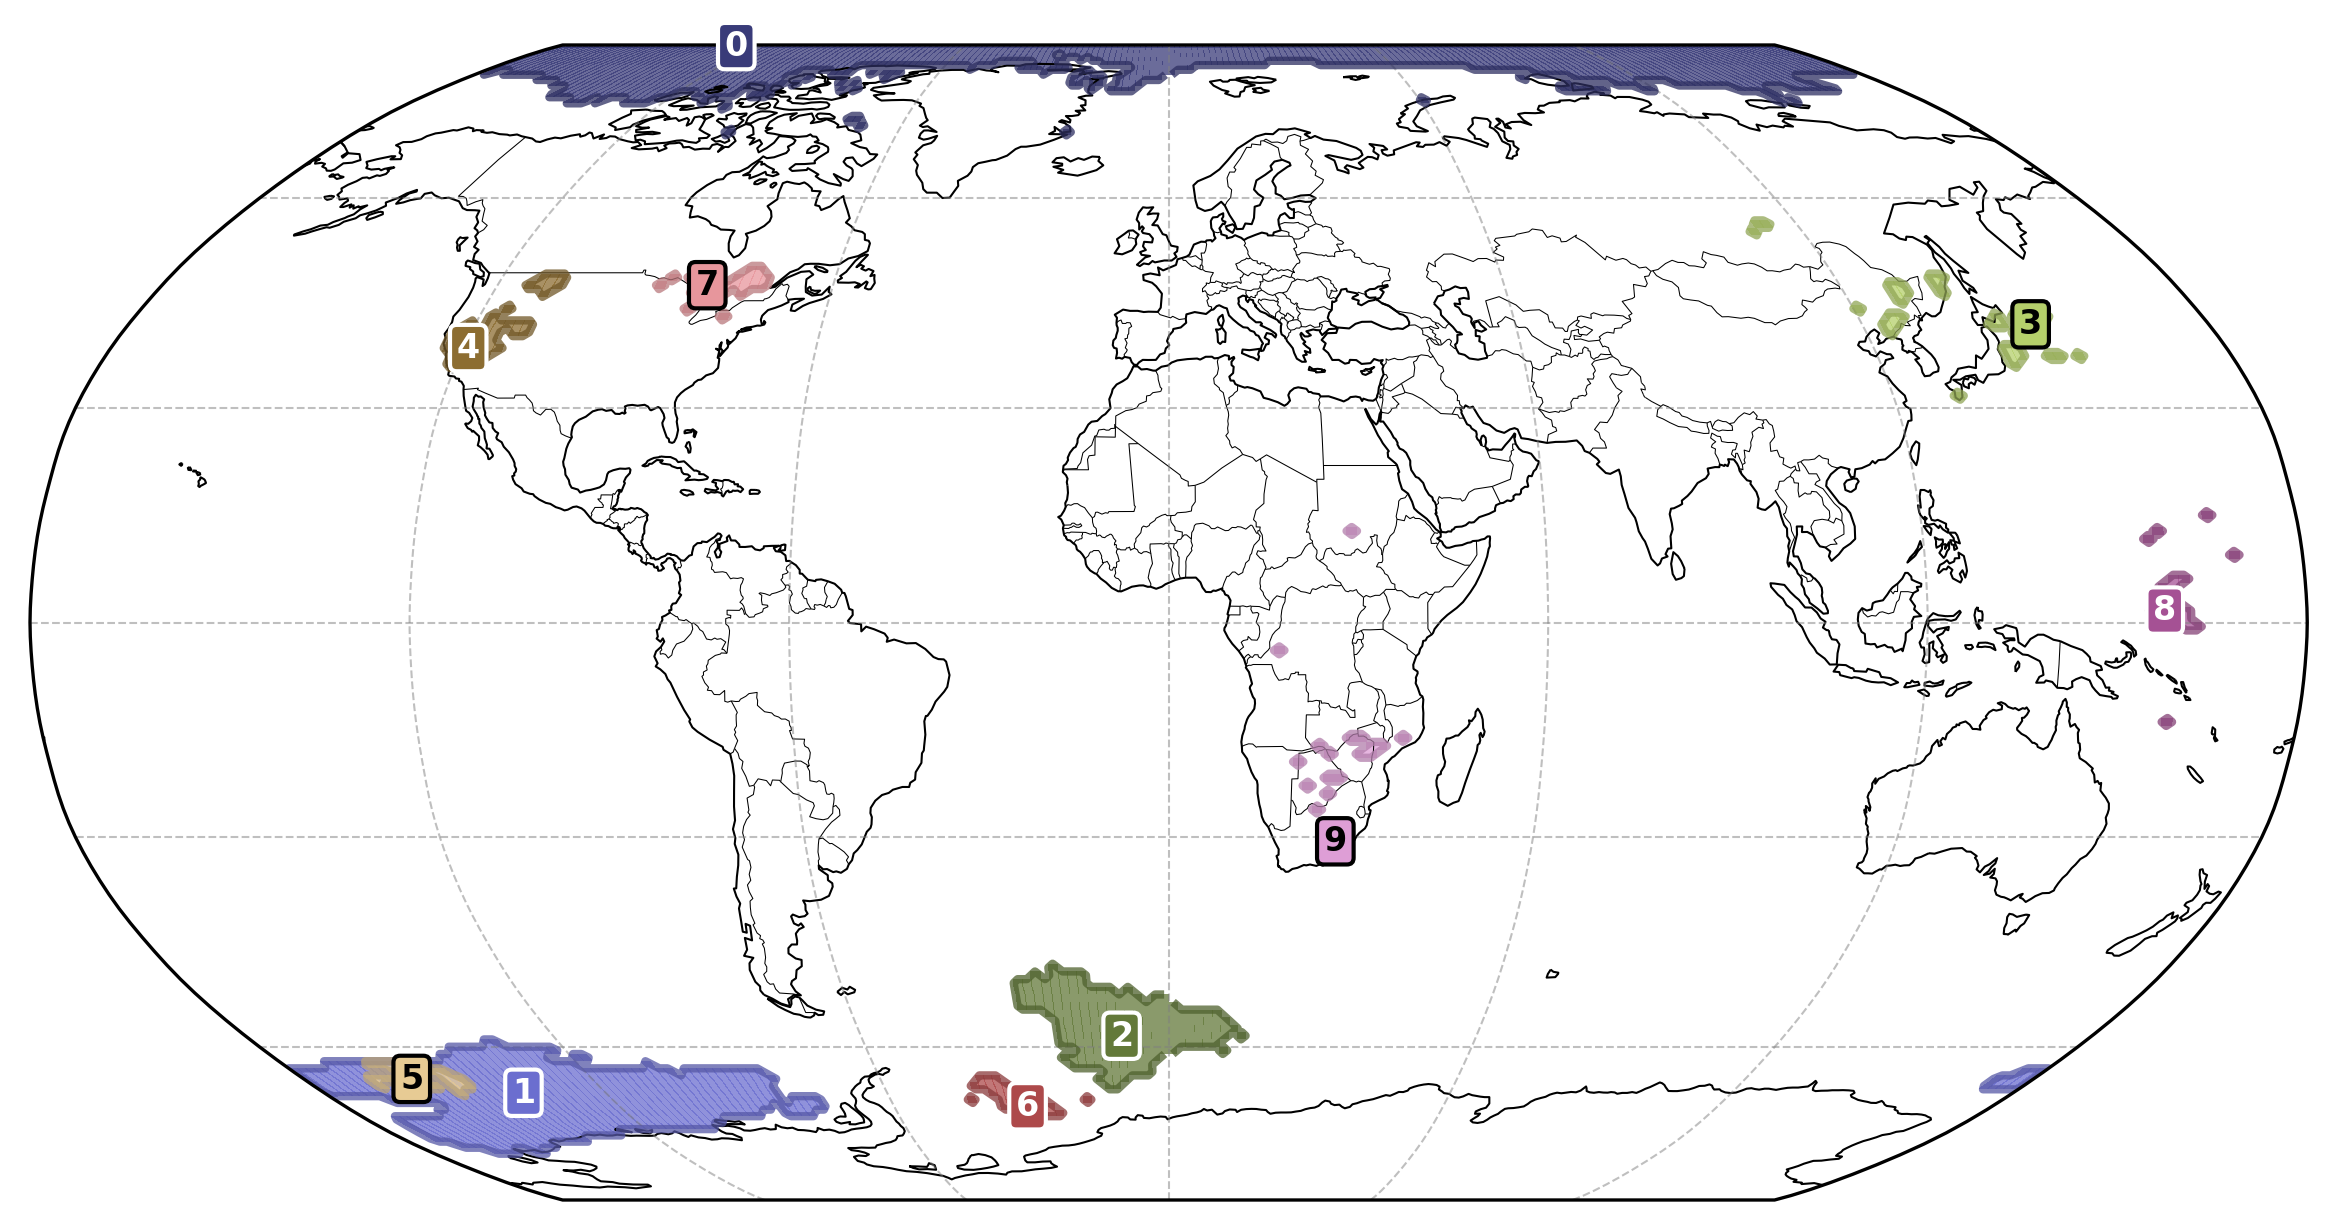

In [ ]:
# Init toad object with .nc file.
td2 = TOAD("test_data/global_mean_summer_tas.nc")

# Coarsen data to speed up computation
td2.data = td2.data.coarsen(lat=2, lon=2, boundary="trim").reduce(np.mean)

# Compute shifts
td2.compute_shifts(
    "tas",
    method=ASDETECT(),
    overwrite=True,
)

# Compute clusters
td2.compute_clusters(
    "tas",
    method=HDBSCAN(min_cluster_size=20),
    shift_threshold=0.6,
    overwrite=True,
)

# Plot clusters
td2.plot.cluster_map("tas", cluster_ids=range(10), projection="global");